In [7]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Criando dados fictícios
dados = pd.DataFrame({
    'Combustível': ['Gasolina', 'Diesel', 'Etanol', 'Gasolina', 'Diesel'],
    'Idade': [3, 5, 2, 8, 1],
    'Quilometragem': [40000, 80000, 25000, 120000, 10000],
    'Preço': [35000, 28000, 45000, 18000, 50000]
})

# Definição das colunas
categorical_features = ['Combustível']
numerical_features = ['Idade', 'Quilometragem']

# Transformadores
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = MinMaxScaler()  # Usando MinMaxScaler para melhor normalização

# ColumnTransformer para processar dados
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Criando o pipeline com RandomForestRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Separação entre treino e teste
X = dados.drop(columns=['Preço'])
y = dados['Preço']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando o modelo
pipeline.fit(X_train, y_train)

# Fazendo previsões
y_pred = pipeline.predict(X_test)

# Avaliação
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Erro Quadrático Médio (MSE): {mse:.2f}')
print(f'Coeficiente de Determinação (R²): {r2:.2f}')


Erro Quadrático Médio (MSE): 91776400.00
Coeficiente de Determinação (R²): nan


C:\Users\bithe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


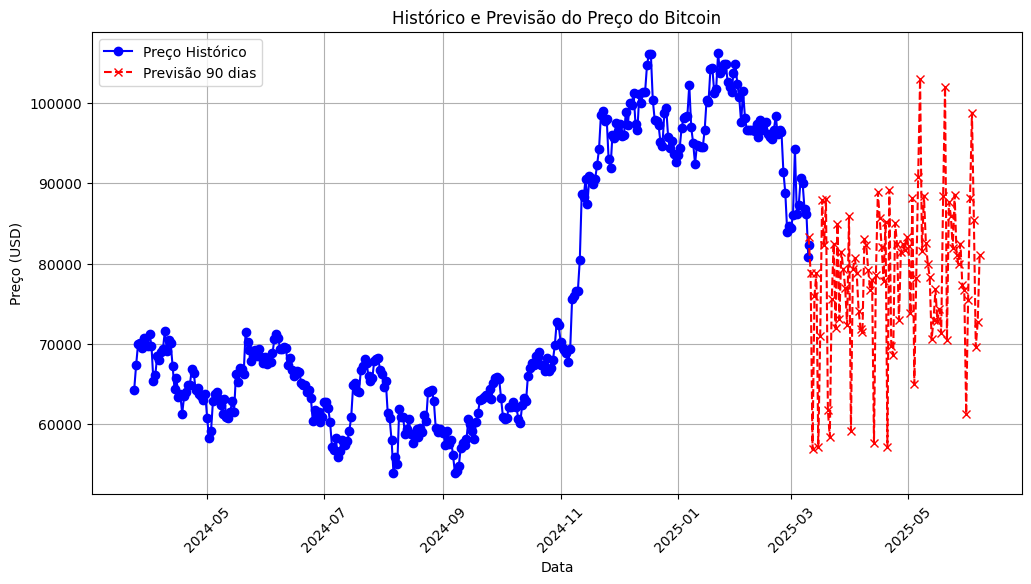

Erro Quadrático Médio (MSE) no conjunto de teste: 4634003.64


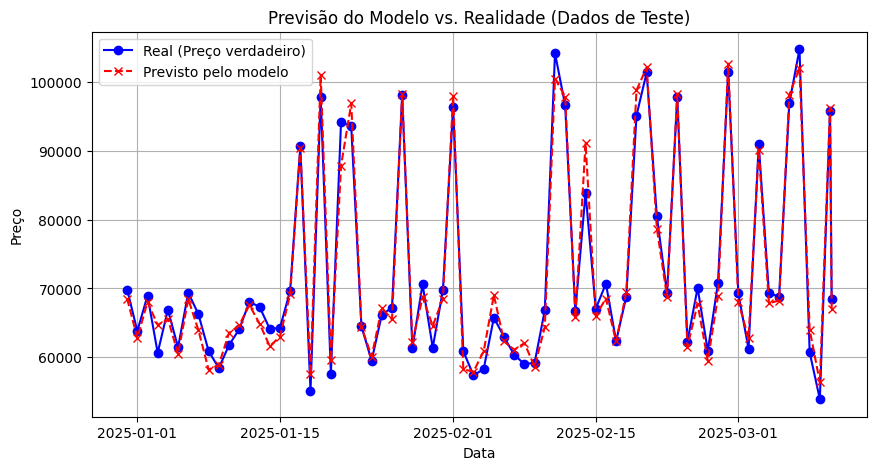

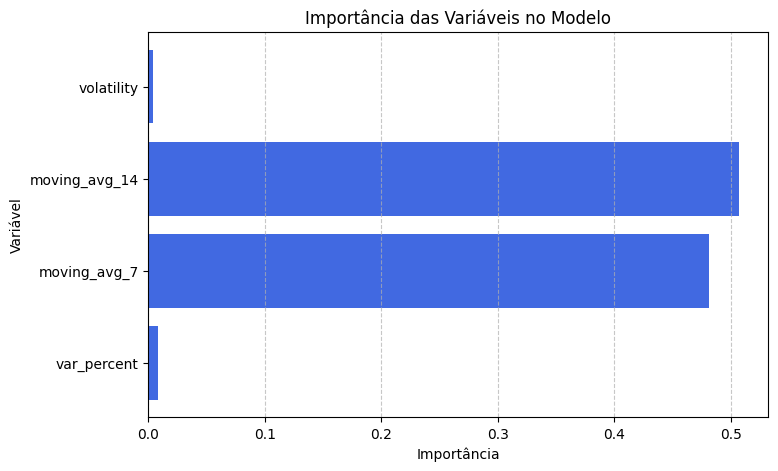

In [16]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 📌 1️⃣ Coletando dados da API
url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
params = {
    "vs_currency": "usd",
    "days": "365",  # Pegamos 1 ano de dados para previsões melhores
    "interval": "daily"
}

response = requests.get(url, params=params)
data = response.json()

# 📌 2️⃣ Criando o DataFrame
precos = pd.DataFrame(data['prices'], columns=['timestamp', 'price'])
precos['timestamp'] = pd.to_datetime(precos['timestamp'], unit='ms')

# 📌 3️⃣ Criando novas variáveis para melhorar as previsões
precos['var_percent'] = precos['price'].pct_change() * 100  # Variação percentual do preço
precos['moving_avg_7'] = precos['price'].rolling(window=7).mean()  # Média móvel de 7 dias
precos['moving_avg_14'] = precos['price'].rolling(window=14).mean()  # Média móvel de 14 dias
precos['volatility'] = precos['price'].pct_change().rolling(window=7).std() * 100  # Volatilidade percentual

# Removendo valores NaN criados pelas médias móveis
precos.dropna(inplace=True)

# 📌 4️⃣ Definição de variáveis preditoras
X = precos[['var_percent', 'moving_avg_7', 'moving_avg_14', 'volatility']]
y = precos['price']

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 5️⃣ Criando e treinando o modelo de regressão
modelo = RandomForestRegressor(n_estimators=200, random_state=42)
modelo.fit(X_train, y_train)

# 📌 6️⃣ Fazendo previsões para os próximos 90 dias
future_dates = pd.date_range(start=precos['timestamp'].max(), periods=90, freq='D')

# Simulando variações futuras com base no comportamento passado
future_data = pd.DataFrame({
    'var_percent': np.random.normal(X_train['var_percent'].mean(), X_train['var_percent'].std(), size=90),
    'moving_avg_7': np.random.normal(X_train['moving_avg_7'].mean(), X_train['moving_avg_7'].std(), size=90),
    'moving_avg_14': np.random.normal(X_train['moving_avg_14'].mean(), X_train['moving_avg_14'].std(), size=90),
    'volatility': np.random.normal(X_train['volatility'].mean(), X_train['volatility'].std(), size=90)
})

future_prices = modelo.predict(future_data)  # Prevê os preços futuros

# Criando um DataFrame para as previsões futuras
previsoes = pd.DataFrame({'timestamp': future_dates, 'price': future_prices})

# 📌 7️⃣ Gráfico 1: Histórico e Previsão para os próximos 90 dias
plt.figure(figsize=(12,6))
plt.plot(precos['timestamp'], precos['price'], marker='o', linestyle='-', color='blue', label='Preço Histórico')
plt.plot(previsoes['timestamp'], previsoes['price'], marker='x', linestyle='--', color='red', label='Previsão 90 dias')
plt.xlabel("Data")
plt.ylabel("Preço (USD)")
plt.title("Histórico e Previsão do Preço do Bitcoin")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# 📌 8️⃣ Avaliando o modelo
y_pred = modelo.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Erro Quadrático Médio (MSE) no conjunto de teste: {mse:.2f}')

# 📌 9️⃣ Gráfico 2: Comparação de previsões vs. valores reais
plt.figure(figsize=(10,5))
plt.plot(precos['timestamp'].iloc[-len(y_test):], y_test, marker='o', linestyle='-', color='blue', label='Real (Preço verdadeiro)')
plt.plot(precos['timestamp'].iloc[-len(y_test):], y_pred, marker='x', linestyle='--', color='red', label='Previsto pelo modelo')
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Previsão do Modelo vs. Realidade (Dados de Teste)")
plt.legend()
plt.grid()
plt.show()

# 📌 🔟 Gráfico 3: Importância das variáveis
importancia = modelo.feature_importances_
plt.figure(figsize=(8, 5))
plt.barh(X_train.columns, importancia, color='royalblue')
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.title("Importância das Variáveis no Modelo")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

